# Project Report

# **Using age, cholesterol and heart rate to classify heart disease patients from Cleveland.**
#### Shreya Arora, Youssef Saleh, Zahra Vink.

### Introduction
The term heart (cardiovascular) disease describes a range of heart conditions that arise from problems with the heart and blood vessels. One of these is coronary artery disease, which is when the arteries supplying blood to the heart narrow. Many risk factors can increase the chance of developing this disease, including cholesterol levels and maximum heart rate (Cleveland Clinic, n.d.).

High levels of cholesterol result in fatty deposits in blood vessels that clog them, making it difficult for enough blood to flow through the arteries. When these deposits break suddenly, they form a clot resulting in a heart attack or stroke. If a patient has heart disease, their maximum heart rate could significantly decrease (WebMD, 2002). 

Thus, our question is: **Is a new patient likely to have heart disease, based on cholesterol levels and maximum heart rate achieved?** To answer this, we will use a knn classifier algorithm.

We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns are as follows:
1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure in mmHg
5. **chol**: serum cholestoral in mg/dl
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate achieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

Each column is numeric-valued and there are 303 rows, with missing data represented as the string "?".

Based on the list above, we will be using `chol` and `thalach` as predictors, to classify patients on whether or not they have heart disease.

### Preprocessing and exploratory data analysis

#### Importing libraries

In [4]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Importing the dataframe

We used `read_csv` to import the processed.cleveland.data dataframe from the online directory.

In [5]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                          col_names = FALSE)

head(cleveland_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


As you can see above, the dataframe does not come with column names, so those must be added. Some factor columns are also being read as `<dbl>` or `<chr>`, so those need to be changed as well.

#### Cleaning and tidying the data

The reason some columns are being read as \<chr> is because they include "?" for unknown values, so we will change those to NA so they can be changed to the types we need.

For this data to be used for a classifier, we need to have a true/false column based on **num**, which we will call **diag**.

In [6]:
set.seed(1)
# assigning col names
cleveland_clean <- cleveland_data

colnames(cleveland_clean) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
                           
# changing "?" into NA
cleveland_data[ cleveland_data == "?" ] <- NA

# adding diag column, setting col types
# as.integer is being used to get rid of decimal points when switching to factor
cleveland_clean <- cleveland_clean %>%
                    mutate(diag = as.factor(ifelse(is.na(num), NA, (num > 0)))) %>%
                    mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
                           fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                           exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
                           ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope))) %>%
                    mutate(num = as_factor(num))

head(cleveland_clean)


Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.factor(as.integer(thal))`.”
Warning message in is.factor(x):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.factor(as.integer(ca))`.”
Warning message in is.factor(x):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,FALSE


Now our table is clean and tidy!

Since `num` uses integers to distinguish presence (1,2,3,4) from absence (0), and we want to determine *whether or not* a patient has heart disease, a new boolean column `diag` has been appended to narrow diagnoses down to TRUE or FALSE. To stratify by it, we made it a factor column.

#### Splitting our data into training and testing sets

Before working on our model, we need to split our data into training and testing sets. Since we want to predict the new column `diag`, we will be stratifying by it.

We will use `initial_split` to split our dataframe into 75% training and 25% testing, since it shuffles our data for us and ensures an equal proportion of each class is present in both. The 75-25 split allows us to train our model on as many data points as possible while also keeping enough data for effective testing later.

In [7]:
#splitting dataframe into training, testing datasets
cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = num)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,FALSE


In the above code, we split the data into a training set to build our model on, and a testing set to, *well*, test it. Using `initial_split` allowed us to shuffle the data before splitting (removing bias and order) and stratify the data by `diag` so that an equal proportion of it in each set.

Moving forward, we will only use the training set until the very end.

#### Summarizing the data

Before we get to work, we need to make sure that the two classes actually have different averages in age, serum cholersterol and maximum heart rate achieved.

To do this, we will use `group_by` and `summarize` to create a table with the minimum, maximum and mean of each of our predictors.

In [8]:
#summarizing to get min, max, mean of each predictor + total no. of rows per class
cleveland_summary <- cleveland_training %>%
                    group_by(diag) %>%
                    summarize(min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol), 
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach),
                              n_of_patients = n())

cleveland_summary

`summarise()` ungrouping output (override with `.groups` argument)



diag,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,141,417,241.2439,96,202,157.6179,123
TRUE,131,353,252.6857,90,182,139.4095,105


To summarize our data, we grouped by `diag` then summarized for the minimum, maximum and mean of `chol` and `thalach`.

We can see that patients with heart disease tend to have higher cholesterol and lower maximum heart rates.

#### Visualizing the realtionship between predictors and class

To visualize the relationship that cholesterol and maximum heart rate achieved have with a patient's diagnosis, we will use `ggplot` to generate a scatter plot of `chol` vs `thalach`, coloring for `diag` 

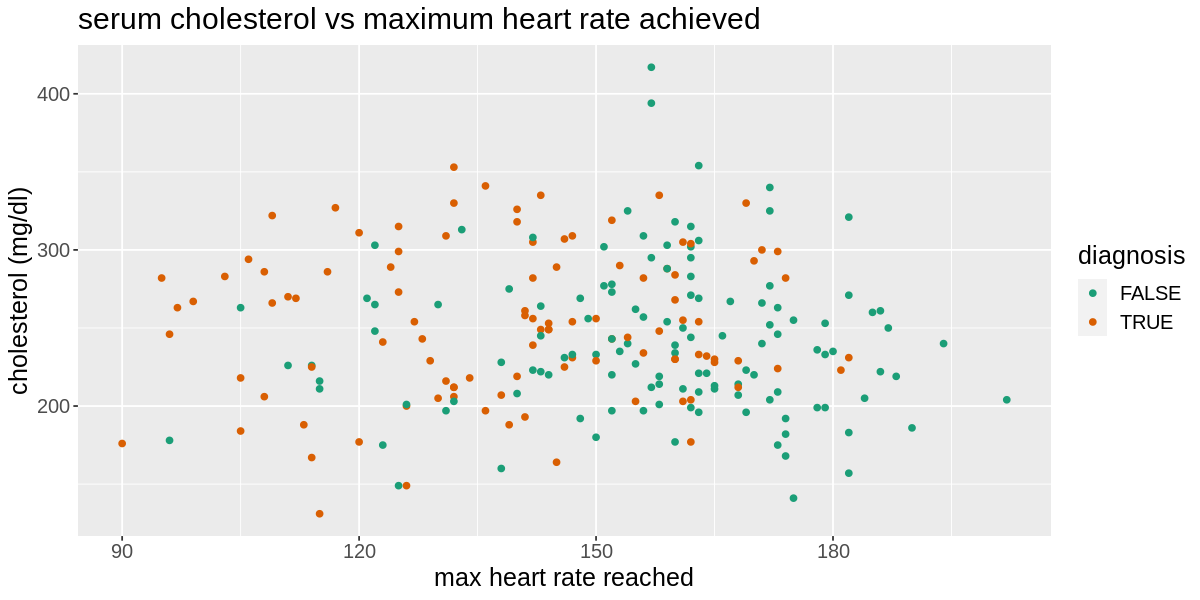

In [9]:
#plotting the training data
chol_thalach <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol (mg/dl)",
                      color = "diagnosis", title = "serum cholesterol vs maximum heart rate achieved") +
                 scale_color_brewer(palette = "Dark2") +
                 theme(text = element_text(size = 15))


chol_thalach

This graph shows that patients with heart disease (orange) tend to have lower maximum heart rates and higher cholesterol, with patients without heart disease (teal) having higher maximum heart rates and a wider range of cholesterol levels.

### Methods
##### Finding Best K Value

Methods for finding the best K value: Our goal is to find the best value for the K-nearest neighbours, providing the highest accuracy and better predictions. We had already split the data into a training and testing set initially, so in the code below, we create a classifier and perform cross-validation to split the training data, train the model with one set and use the other to evaluate it because we can not use testing data.

1) First, we use the recipe function, which preprocesses the data centered, scaled and balanced.

2) Then we performed the cross-validation with ten folds using the vfold_cv function on the training data. We used ten folds because if we split the data once, the results strongly depend on the observations that ended up being in the validation set, so using more folds increases the accuracy.

3) Then we created a k nearest model but replaced neighbours=tune instead of an actual value since we are trying to find the best k-nearest neighbours value.

4) We add the recipe and model to a workflow using workflow().Tune_grid function runs cross validation on a range of k nearest neighbours values that is specified in gridvals

5) Then we find the best K value by filtering for the accuracy and plotting a scatter plot with the accuracy estimate on the y axis and k nearest neighbour value on the x-axis.

##### Building Our Classifier

1) We made a new model specification for the best K value chosen, combined it with the recipe made earlier in a workflow, and retrained the classifier with “fit”.

2) The predict function was used to evaluate the classifier’s prediction accuracy, using bind_cols to add a column of predictions to the test data.

3) We collected statistics about the quality of our model using metrics, filtering for the .metric column for accuracy, for which we got 68%. This is much better than the 53% that the majority classifier had, demonstrating that the K-nearest neighbours classifier improved on the majority one.

4) A confusion matrix was also made to get a sense of which classifications the classifier was accurate at giving.

##### Visualizing Our Results

5) To visualize our results, we plotted the predictions using the x axis for max heart rate, the y axis for cholesterol levels, and coloured by diagnosis. This allowed us to quickly identify trends in our predictors that our classifier used to create its predictions.

#### Creating the model

To create our model, we need to follow four steps:

1. create a recipe that uses `cleveland_training` to predict `diag`, with `chol` and `thalach` as predictors.
2. create a specification that uses k-nearest neighbors, with `neighbors = tune()` to perform cross-validation.
3. split the data into 10 equally sized chunks, known as folds, stratifying by `diag`.
4. create a worflow combining the first 2 steps, with `tune_grid` instead of `fit`.
5. repeat for each validation set for values of 1 ≤ $k$ ≤ 100

To get the same folds each time, we need to set the seed to 1.

In [10]:
set.seed(1)

# Performing Standardization 
cleveland_recipe <- recipe(diag ~ chol + thalach , data = cleveland_training) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# Perform 10 fold-cross valdiation
cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = diag)

gridvals <- tibble(neighbors = c(1:100))

# Create workflow
knn_results <- workflow() %>%
      add_recipe(cleveland_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = cleveland_vfold, grid = gridvals) %>%
# Collect metrics, filter for accuracy
      collect_metrics() %>%
      filter(.metric == "accuracy") %>%
      select(neighbors, mean) %>%
      arrange(desc(mean))

head(knn_results)

neighbors,mean
<int>,<dbl>
73,0.7038702
74,0.7038702
83,0.6987813
84,0.6987813
57,0.6949769
77,0.6947958


Both $k$ = 73 and $k$ = 74 give us 70.4% accuracy!
To pick one, we should plot a line graph of accuracy vs $k$.

#### Visualizing accuracy

Using `geom_line`, we will be able to view how "safe" each choice is, that is how big of a difference in accuracy a difference of $k$ ± 1 would cause. To do this, we need to plot a graph of accuracy vs neighbors.

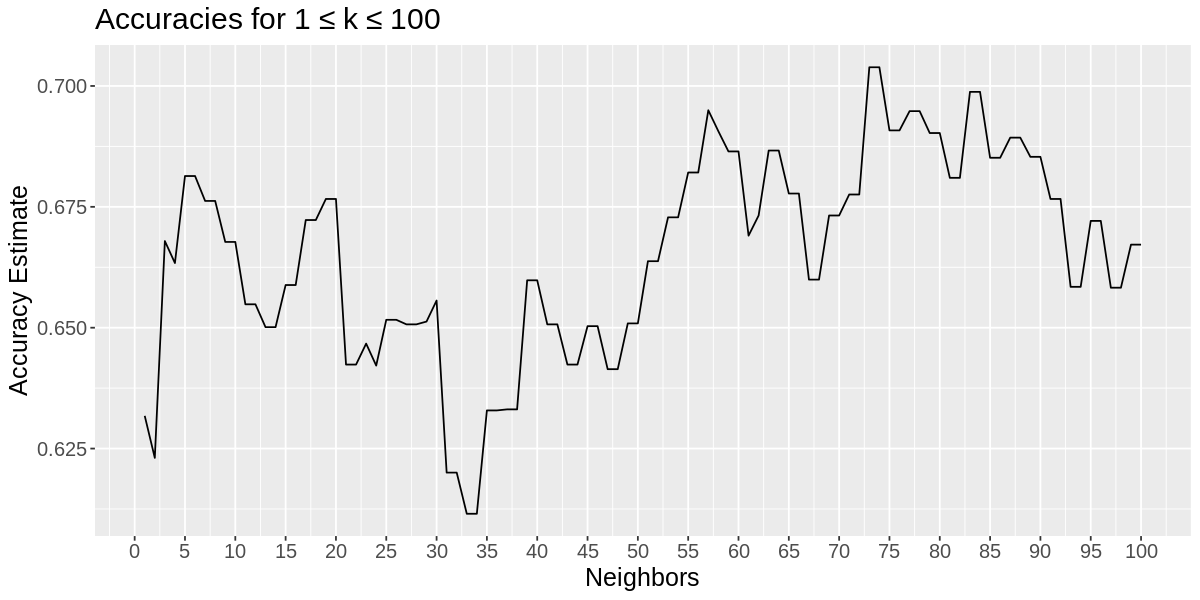

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)

accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      #geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 100") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k

Looking at the graph above, $k$ = 74 gives us the "safest" value of $k$, because the drops to either side of the point are significantly less steep than the drop from 73 to 72.

#### Comparing to a majority classifier

We still, however, need to compare this accuracy to a majority classifier.

To do this, we will `group_by` diagnosis and `summarize` to get the percentage of the most abundant class.

In [10]:
#Comparing accuracy of classifier with majority classifier
cleveland_proportions <- cleveland_training %>%
    group_by(diag) %>%
    summarize(n=n()) %>%
    mutate(percent = 100*n/nrow(cleveland_training))
cleveland_proportions

`summarise()` ungrouping output (override with `.groups` argument)



diag,n,percent
<fct>,<int>,<dbl>
FALSE,123,53.94737
TRUE,105,46.05263


We can deduce that a FALSE diagnosis represents the majority of the training data with 53.9% of all results. Therefore, our classifier is more accurate than a majority classifier.

#### Creating the final model

Now that we have a value for $k$, we can create our final spec using `neighbors = 74`. We then fit it to `cleveland_training`.

In [13]:
set.seed(1)

final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 74)%>%
    set_engine("kknn")%>%
    set_mode("classification")

fit <- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(final_spec)%>%
    fit(data = cleveland_training)

fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~74, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3289474
Best kernel: rectangular
Best k: 74

Great, we have a working model now!

In [2]:
train_predictions <- predict(fit, cleveland_training) %>%
    bind_cols(cleveland_training)

thalach_grid <- seq(min(cleveland_clean$thalach), 
                max(cleveland_clean$thalach), 
                length.out = 100)

chol_grid <- seq(min(cleveland_clean$chol), 
                max(cleveland_clean$chol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(thalach = thalach_grid, 
                                chol = chol_grid))

knnPredGrid <- predict(fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
                    rename(diag = .pred_class)


plot_results <- ggplot() + 
                geom_point(data = train_predictions, 
                mapping = aes(x = thalach, y = chol, color = diag), 
                alpha = 0.75) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = thalach, 
                           y = chol, 
                           color = diag), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", 
                     color = "Diagnosis", 
                     title = "Regions of each diagnosis") +
                scale_color_brewer(palette = "Dark2") +
                theme(text = element_text(size = 15))

plot_results

ERROR: Error in predict(fit, cleveland_training) %>% bind_cols(cleveland_training): could not find function "%>%"


We plotted the graph above to tell us whether our the classifier results in overfitting or underfitting which can cause our classifier to become unreliable on new data. Looking at the graph above the classifer is neither underfitting or overfitting and therefore we can trust that our classifier will be able to predict new data. 

In [1]:
set.seed(1)

#predict
predictions <- predict(fit, cleveland_testing) %>%
               bind_cols(cleveland_testing)

head(predictions)
tail(predictions)

#find the accuracy of the predictions
metrics<- predictions %>%
    metrics(truth = diag, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions %>%
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

ERROR: Error in predict(fit, cleveland_testing) %>% bind_cols(cleveland_testing): could not find function "%>%"


Our classifier labeled 51 out of 75 observations correctly. It also seems to be twice as likely to overdiagnose (16) than under diagnose (8). This is not a terrible error if the classifier is intended to be used before rather than instead of going to a doctor. Medically speaking, it is better to err on the side of caution when it comes to predicting diagnoses.

### Discussion
#### Answering the predictive question

The question that we were trying to answer by using our classifier was this: “Is a new patient likely to have heart disease, based on age, cholesterol levels and maximum heart rate achieved?”
To answer this question, we made a classifier that diagnosed heart diseased using age, cholesterol levels, and maximum heart rate achieved.

#### Expected findings vs outcome

We are expecting a high accuracy for our classifier, roughly above 60%. This was deduced considering that the visualizations between the predictors and target variables depicted clustering of the data points for each diagnosis (TRUE/FALSE), indicating a relatively strong causal relationship with the target variable.

In our proposal, we also expected that a patient prone to heart disease will tend to have higher levels of cholesterol and higher maximum heart rates. As mentioned in the introduction both high cholesterol and high blood pressure is likely due to the patients having clogged arteries and therefore restricted blood flow/blood being pumped which greatly increases the risk of having heart disease.

Our classifier’s accuracy was around 70%, in accordance with our prediction. Our visualizations showed that our classifier diagnosed patients with heart disease who tended to have higher levels of cholesterol and higher maximum heart rates.

Our findings are as expected: a patient prone to heart disease tends to have higher levels of cholesterol and higher maximum heart rates. As mentioned in the introduction both high cholesterol and high blood pressure is likely due to the patients having clogged arteries and therefore restricted blood flow/blood being pumped which greatly increases the risk of having heart disease.

#### Impact of these findings

Being able to have a classification system for heart disease could make it easier and more accurate for doctors to diagnose patients, resulting in earlier treatment. It could also save doctors time since they already have a clue as to what the diagnosis could be. Therefore, they could spend less time with patients who have a false diagnosis and more with those that have a true one, maximizing the efficiency of the medical system. Having a high level of accuracy in diagnosis is important because a false diagnosis could be fatal. Although the accuracy of the classifier is fairly high, we recommend that it is used as a preliminary prediction prior to visiting a professional, who then can confirm the diagnosis since it is not perfectly accurate.

#### What future questions could this lead to?

- What is the average cholesterol level of a average middle aged person?
- What other factors other than cholesterol and heart rate impact the chance of a person getting heart disease?
- What is the mean level of blood pressure in a patient with heart disease?

### Bibliography

Detecting and Treating Heart Failure. (2002, November 1). WebMD. https://www.webmd.com/heart-disease/heart-failure/understanding-heart-failure-treatment.

Preventing & reversing cardiovascular disease. Cleveland Clinic. (n.d.). Retrieved November 6, 2021, from https://my.clevelandclinic.org/health/articles/17385-cardiovascular-disease-prevention--reversal. 

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019, April 27). Cardiovascular risks associated with gender and aging. Journal of cardiovascular development and disease. Retrieved November 10, 2021, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/.

The creators of the Heart Disease Database are:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.